In [11]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import pandas as pd
import random as rnd
import math, os, time, sys, re, datetime
from datetime import timedelta
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import stats

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#testset = 'A0202'
#INPUTS: python DLMHC.py 0 A0202
#testset = sys.argv[2] # e.g. takes A0202 as input allele name
testset = "A0101"

print("Test set is ", testset)
runindx = 0 

###all the possible sequence letters
allSequences = 'ACEDGFIHKMLNQPSRTWVYZ'
# Establish a mapping from letters to integers
char2int = dict((c, i) for i, c in enumerate(allSequences))

Tensorflow version 2.7.0
Num GPUs Available:  1
Test set is  A0101


In [12]:
def getdata_onehot(datafile):   #build testing matrix
    ### READ in test dataset
    """ Reads the test data file and extracts allele subtype,
            peptide length, and measurement type. Returns these information
            along with the peptide sequence and target values.
    """
    #train数据载入
    import os
    traindata = os.path.join("./../DATA", "train_data", datafile )
    print("traindata name: ", traindata)
    df_train = pd.read_csv(traindata, header=0)
    df_train = df_train[df_train.Peptide.str.contains('X') == False]
    df_train = df_train[df_train.Peptide.str.contains('B') == False]
    df_train = df_train[df_train.Peptide.str.contains('U') == False]
    #eg.df_train = pd.read_csv('./DATA/train_data/A0202',sep="\t")
    
    #下采样
    new_df_0 = df_train.loc[df_train['BindingCategory']== 0].sample(frac = 1)
    #上采样
    df_1_list = []
    for i in range(4):
        df_1_list.append(df_train.loc[df_train['BindingCategory']== 1])
        new_df_1 = pd.concat(df_1_list)
    new_df_train = pd.concat([new_df_0,new_df_1])
    new_df_train = new_df_train.sample(frac = 1.0) #shuffle


    #X_train--补齐11mer--one_hot_matrix
    train_data=transformEL(new_df_train)
    trainMatrix = np.empty((0, 11,len(allSequences)), int)      
    for num in range(len(train_data.Peptide)):
        if num%1000 == 0:
            print(train_data.Peptide.iloc[num],num)
        trainMatrix = np.append(trainMatrix, [Pept_OneHotMap(train_data.Peptide.iloc[num])], axis=0)
    allele_name = train_data['HLA'][0]
    assert (trainMatrix.shape[0] == train_data.shape[0])

    #test数据载入
    testdata = os.path.join("./../DATA", "test_data", datafile )
    df_test = pd.read_csv(testdata, header=0)
    df_test = df_test[df_test.Peptide.str.contains('X') == False]
    df_test = df_test[df_test.Peptide.str.contains('B') == False]
    df_test = df_test[df_test.Peptide.str.contains('U') == False]
    #eg.df_test = pd.read_csv('./DATA/test_data/A0202',sep="\t")

    #X_test--补齐11mer--one_hot_matrix
    test_data=transformEL(df_test)
    testMatrix = np.empty((0, 11,len(allSequences)), int)      
    for num in range(len(test_data.Peptide)):
        if num%1000 == 0:
            print(test_data.Peptide.iloc[num],num)
        testMatrix = np.append(testMatrix, [Pept_OneHotMap(test_data.Peptide.iloc[num])], axis=0)
    assert (testMatrix.shape[0] == test_data.shape[0])

    Y_train = train_data.BindingCategory
    Y_test = test_data.BindingCategory 
    #
    Y_train = Y_train.reset_index(drop=True)
    Y_test = Y_test.reset_index(drop=True)
    #
    trainlen = len(trainMatrix)
    ss1 = list(range(trainlen))
    rnd.shuffle(ss1)    #
    
    # combine training and test datasets
    datasets={}
    datasets['X_train'] = trainMatrix
    datasets['Y_train'] = Y_train.values #traindata.BindingCategory.as_matrix()
    datasets['X_test'] = testMatrix
    datasets['Y_test'] = Y_test.values    

    return datasets

def Pept_OneHotMap(peptideSeq):
    """ maps amino acid into its numerical index
    USAGE
    Pept_OneHotMap('A')
    array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    """
    # integer encode input data
    integer_encoded=[char2int[char] for char in peptideSeq]
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
    	letter = [0 for _ in range(len(allSequences))]
    	letter[value] = 1
    	onehot_encoded.append(letter)
    return np.asarray(onehot_encoded)

def transformEL(dataset):
    dataset = dataset.reset_index(drop=True)
    peptide=dataset.Peptide
    peptide2list=peptide.tolist()
    for i in range(len(peptide)):
        if len(peptide2list[i]) < 11:
            n1 = len(peptide2list[i]) // 2
            n2 = 11 - len(peptide2list[i])
            peptide2list[i] = peptide2list[i][:n1] + 'Z'*n2 + peptide2list[i][n1:]     #将小于11个氨基酸的peptide在中间插空补齐
        else:
            peptide2list[i] = peptide2list[i][:11]

    del dataset['Peptide']
    peptides = pd.DataFrame(peptide2list,columns=['Peptide'])
    dataset.insert(0,'Peptide',peptides.pop('Peptide'))
    return dataset

def binary2onehot(yy):
    yy2= np.zeros((len(yy),2), dtype=int) #yy2.shape #(10547, 2)
    for num in range(len(yy)):
        if yy[num]==1:
            yy2[num,0]=1
        else:
            yy2[num,1]=1
    return yy2

In [13]:
data=getdata_onehot(datafile=testset)

traindata name:  ./../DATA/train_data/A0101
EPPRAZGGPHT 0
RKDEZZNSING 1000
QKQDDTLAELP 2000
SSVLDZKKEGE 3000
YVIYFTKLLGS 4000
TDVVZZISAAC 5000
NNVAZZEFVCK 6000
SKKKZZKMIST 7000
AKTEZZPFTQG 8000
LQTRZZEDIRN 9000
LTDIZZKLGKY 10000
LVSDTZIGQRV 11000
TFFQZZTASGK 12000
TTDLZZELIKY 13000
IFYAGIRIFLS 14000
YIEFHSQSGFY 15000
PVPTPZVVLKP 16000
DSEDEZDEEVG 17000
MGDPGARVYSS 18000
TTSHLZMGMFY 19000
VDPEDZTNLNQ 20000
FLDDKZQWLTT 21000
KVTEZZKVVVK 22000
KRICEIQAVDC 23000
LGKLZZHPSSS 24000
EVDMZZDLDSY 25000
GFGFVZRFTEY 26000
EEKTPDSYLGL 27000
SSSGZZDPAEY 28000
SFCFKZANPGT 29000
RVATTTFITLS 30000
LMYLZZFPRQL 31000
TERGQZQEAKL 32000
PEQEZZQLMVV 33000
FADGZZFVLVY 34000
AGDVZZTGSAI 35000
SQPGFZSAGPS 36000
TAEEGZVQLSQ 37000
LSDPPZGAGTY 38000
LGSSZZGASQR 39000
VQVQZZLVQDD 40000
LVPLHZPGFFT 41000
SADYIZGGSHY 42000
EPFLZZFNFLY 43000
SSEENYYSTSY 44000
IMAYLZFTIFN 45000
SGRSSZEEPGV 46000
NRTSAYSLEHA 47000
HPVSEEIEFKE 48000
DMTSEZEFRQV 49000
SPETEZSPLQG 50000
RPRPZZPRTTP 51000
RMDPLTKPMQY 52000
KTDLZZDLDGY 530

In [60]:
shuffle_ = np.arange(len(data['Y_train']))
np.random.shuffle(shuffle_)
data['Y_train']=data['Y_train'][shuffle_]
data['X_train']=data['X_train'][shuffle_]

print("X_Train size ", data['X_train'].shape)
print("Y_Train size ", data['Y_train'].shape)
print("Train data value=1 ", np.sum(data['Y_train']==1))
print("X_Test size " , data['X_test'].shape)
print("Y_Test size " , data['Y_test'].shape)
print("Test data value=1 ", np.sum(data['Y_test']==1))


Y_train_labels = binary2onehot(data['Y_train']) # binary output converted into two classes
Y_test_labels = binary2onehot(data['Y_test'])
X_train_data = data['X_train']  #already one hot encoded
X_test_data = data['X_test']

X_Train size  (53892, 11, 21)
Y_Train size  (53892,)
Train data value=1  11192
X_Test size  (6600, 11, 21)
Y_Test size  (6600,)
Test data value=1  600


In [61]:
# save proceed data to txt
print("X_Train size ", X_train_data.shape)
print("Y_Train size ", Y_train_labels.shape)
print("X_Test size " , X_test_data.shape)
print("Y_Test size " , Y_test_labels.shape, "\n")

X_train_data_reshape = X_train_data.reshape(X_train_data.shape[0], -1)
X_test_data_reshape = X_test_data.reshape(X_test_data.shape[0], -1)
np.savetxt("data_train.txt", X_train_data_reshape, fmt='%i')
np.savetxt("data_test.txt", X_test_data_reshape, fmt='%i')

np.savetxt("data_train_labels.txt", Y_train_labels, fmt='%i')
np.savetxt("data_test_labels.txt", Y_test_labels, fmt='%i')

# from txt to numpy
X_train_data = np.loadtxt("data_train.txt")
X_train_data = X_train_data.reshape(X_train_data.shape[0], 11, 21)
X_test_data = np.loadtxt("data_test.txt")
X_test_data = X_test_data.reshape(X_test_data.shape[0], 11, 21)
Y_train_labels = np.loadtxt("data_train_labels.txt")
Y_test_labels = np.loadtxt("data_test_labels.txt")

print("X_Train size ", X_train_data.shape)
print("Y_Train size ", Y_train_labels.shape)
print("X_Test size " , X_test_data.shape)
print("Y_Test size " , Y_test_labels.shape)

print ("finish loading")

X_Train size  (53892, 11, 21)
Y_Train size  (53892, 2)
X_Test size  (6600, 11, 21)
Y_Test size  (6600, 2) 

X_Train size  (53892, 11, 21)
Y_Train size  (53892, 2)
X_Test size  (6600, 11, 21)
Y_Test size  (6600, 2)
finish loading


In [62]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# simple model
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(11, 21, 1)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))


In [65]:
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_data, Y_train_labels, epochs=20, validation_split = 0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 10, 20, 32)        160       
                                                                 
 conv2d_16 (Conv2D)          (None, 9, 19, 64)         8256      
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 18, 64)         16448     
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                589888    
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 614,882
Trainable params: 614,882
Non-tr

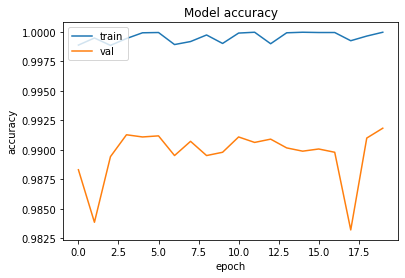

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#plt.savefig('accuracy.png')

<Figure size 432x288 with 0 Axes>